In [1]:
import sys
sys.path.append('./helpers')
sys.path.append('./optimizers')

In [2]:
# External libraries
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import networkx as nx
from deap import gp

# Custom functions and classes
from pymoo_optimizer import PymooOptimizer
import benchmark as Benchmark
import data_provider as dp

In [3]:
x_train, x_test, x_val, y_train, y_test, y_val = dp.get_train_test_validation_data('breast', 0.8, 0.1)

In [4]:
optimizer = PymooOptimizer(x_train, x_val, y_train, y_val)
solution, score = optimizer.optimize(64, 100, Benchmark.dtree_accuracy, verbose = False)

In [5]:
raw_score = np.round(Benchmark.dtree_accuracy(x_train, x_test, y_train, y_test) * 100, 2)
optimized_score = np.round(Benchmark.dtree_accuracy(x_train.loc[:, solution], x_test.loc[:, solution], y_train, y_test) * 100, 2)
print(f'After optimization, decision tree accuracy changed from {raw_score}% to {optimized_score}%\n\n' +
        f'Optimal contains {np.round((x_train.shape[1] - np.sum(solution)) / x_train.shape[1] * 100, 1)}% less columns than the original dataset,' +
        f'reducing from {x_train.shape[1]} to {np.sum(solution)}\n\nSelected columns are: {", ".join(x_train.columns[solution].tolist())}')


After optimization, decision tree accuracy changed from 85.18% to 95.26%

Optimal contains 73.3% less columns than the original dataset,reducing from 30 to 8

Selected columns are: radius1, area1, smoothness1, fractal_dimension1, concave_points2, symmetry2, area3, concave_points3


In [6]:
# Evolve a new feature
x_train_2 = x_train
x_test_2 = x_test
x_val_2 = x_val
best_feature_func, _ = optimizer.evolve_new_feature(epochs=50, heuristics=Benchmark.dtree_accuracy)

# Apply the evolved feature to the training and test sets
x_train_2["evolved_feature"] = x_train_2.apply(lambda row: best_feature_func(*row), axis=1)
x_test_2["evolved_feature"] = x_test_2.apply(lambda row: best_feature_func(*row), axis=1)
x_val_2["evolved_feature"] = x_val_2.apply(lambda row: best_feature_func(*row), axis=1)

# Evaluate the model with the new feature added
score_with_new_feature = np.round(Benchmark.dtree_accuracy(x_train_2, x_test_2, y_train, y_test) * 100, 2)
optimizer_2 = PymooOptimizer(x_train_2, x_val_2, y_train, y_val)
solution, score = optimizer_2.optimize(64, 100, Benchmark.dtree_accuracy, verbose = False)
optimized_score_with_new_feature = np.round(Benchmark.dtree_accuracy(x_train_2.loc[:, solution], x_test_2.loc[:, solution], y_train, y_test) * 100, 2)
print(f'After feature creation, decision tree accuracy set to {score_with_new_feature}%\n\n' +
      f'After feature creation and selection, decision tree accuracy set to {optimized_score_with_new_feature}%\n\n' +
        f'Optimal contains {np.round((x_train.shape[1] - np.sum(solution)) / x_train.shape[1] * 100, 1)}% less columns than the original dataset,' +
        f'reducing from {x_train.shape[1]} to {np.sum(solution)}\n\nSelected columns are: {", ".join(x_train.columns[solution].tolist())}')

gen	nevals	avg     	std       	min     	max     
0  	50    	0.909805	0.00635834	0.894486	0.920551
1  	33    	0.909123	0.00563837	0.894486	0.920301
2  	28    	0.910842	0.0052219 	0.895739	0.920301
3  	28    	0.911208	0.00505199	0.899248	0.920301
4  	41    	0.908722	0.00633565	0.895238	0.922055
5  	29    	0.910757	0.00597456	0.897744	0.922055
6  	37    	0.910842	0.00741479	0.878697	0.923058
7  	31    	0.912561	0.00639695	0.899499	0.931328
8  	32    	0.911694	0.0076076 	0.895489	0.923058
9  	25    	0.913043	0.00738476	0.895739	0.923058
10 	34    	0.911519	0.00872957	0.895739	0.934837
11 	30    	0.913764	0.00870636	0.896992	0.939348
12 	26    	0.914972	0.00872451	0.894987	0.934837
13 	34    	0.913955	0.00951727	0.894236	0.935088
14 	30    	0.916797	0.0101107 	0.89198 	0.935338
15 	28    	0.922576	0.0114303 	0.896241	0.946115
16 	27    	0.92391 	0.012798  	0.900501	0.946115
17 	33    	0.919754	0.0142416 	0.897995	0.94411 
18 	28    	0.92003 	0.0144035 	0.896491	0.945113
19 	33    	0.924747	

In [7]:
x_train.drop(columns=["evolved_feature"], inplace=True)
x_test.drop(columns=["evolved_feature"], inplace=True)
x_val.drop(columns=["evolved_feature"], inplace=True)

Feature as math expression: mul(protected_sqrt(smoothness3), add(add(perimeter3, square_root(fractal_dimension2)), texture3)) 



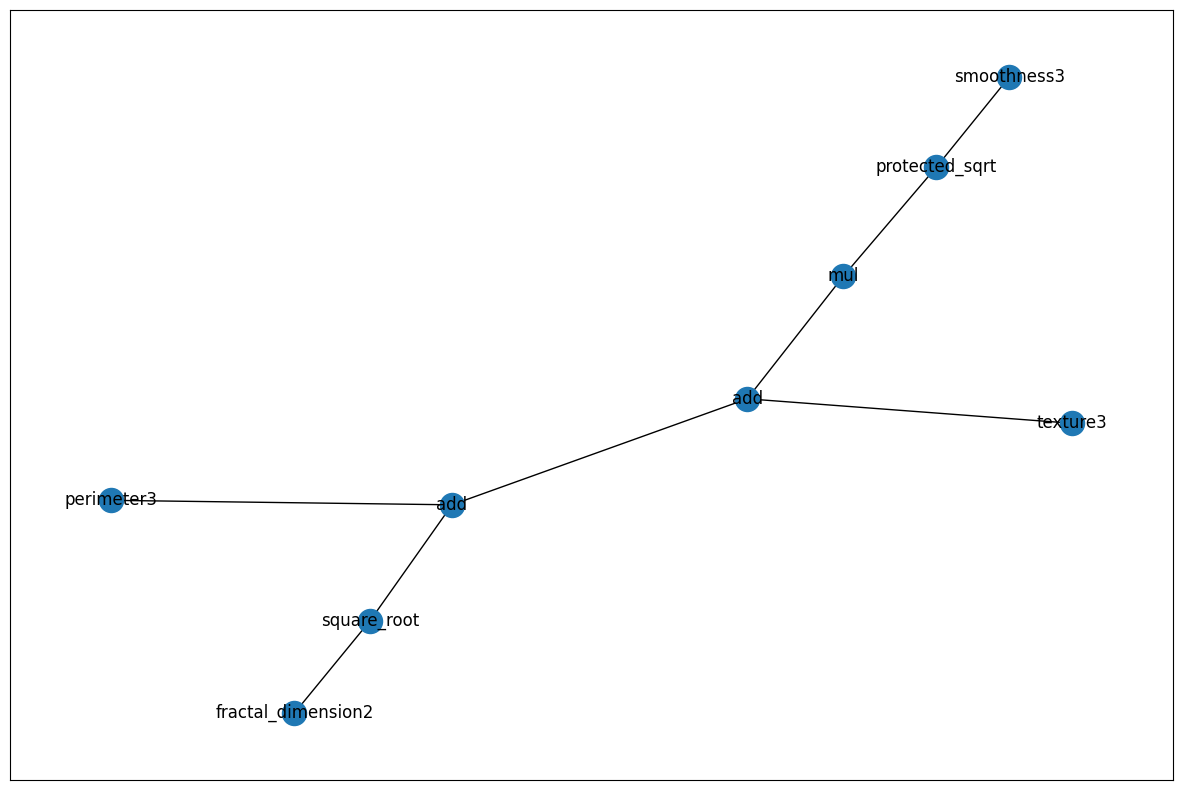

Feature as math expression: sin(concave_points3) 



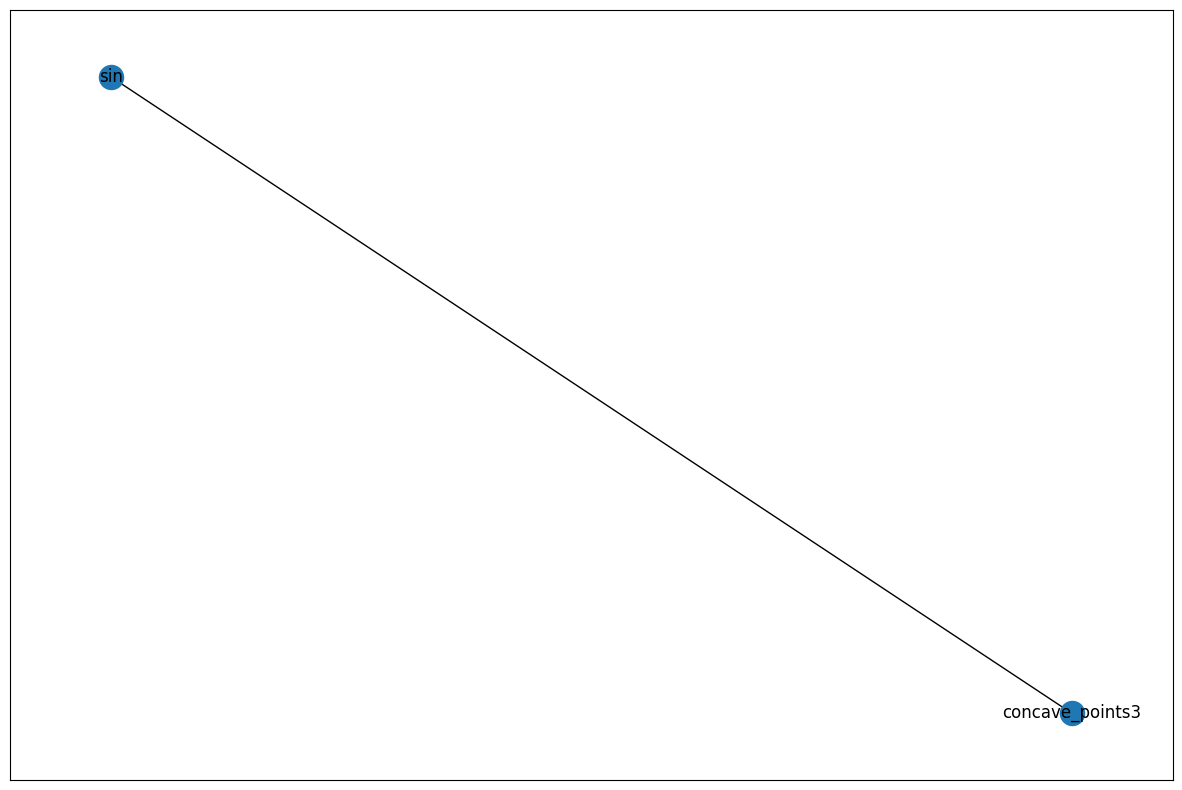

After feature creation, decision tree accuracy was equal to 99.12%

With previous data, it was 87.81%

Optimal contains 93.3% less columns than the original dataset, list of columns: evolved_feature_1, evolved_feature_2


In [9]:
# Evolve a new set of features
x_train_2 = pd.DataFrame({})
x_test_2 = pd.DataFrame({})
x_val_2 = pd.DataFrame({})

old_accuracy = 0
new_accuracy = 1
feature_count = 0

while new_accuracy - old_accuracy > 0:
    old_accuracy = new_accuracy
    feature_count += 1
    optimizer = PymooOptimizer(pd.concat([x_train, x_train_2], axis=1), pd.concat([x_val, x_val_2], axis=1), y_train, y_val)
    best_feature_func, best_individual = optimizer.evolve_new_feature(epochs=50, heuristics=Benchmark.dtree_accuracy, verbose=False, target_train = x_train_2, target_test = x_val_2)
    print("Feature as math expression:", best_individual, "\n")
    
    nodes, edges, labels = gp.graph(best_individual)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = nx.spring_layout(g)

    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(g, pos)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)
    plt.show()
    
    x_train_2[f'evolved_feature_{feature_count}'] = pd.concat([x_train, x_train_2], axis=1).apply(lambda row: best_feature_func(*row), axis=1)
    x_test_2[f'evolved_feature_{feature_count}'] = pd.concat([x_test, x_test_2], axis=1).apply(lambda row: best_feature_func(*row), axis=1)
    x_val_2[f'evolved_feature_{feature_count}'] = pd.concat([x_val, x_val_2], axis=1).apply(lambda row: best_feature_func(*row), axis=1)
    
    new_accuracy = np.round(Benchmark.dtree_accuracy(x_train_2, x_test_2, y_train, y_test) * 100, 2)

score = np.round(Benchmark.dtree_accuracy(x_train, x_test, y_train, y_test) * 100, 2)

print(f'After feature creation, decision tree accuracy was equal to {new_accuracy}%\n\n' +
        f'With previous data, it was {score}%\n\n' +
        f'Optimal contains {100 - np.round(x_train_2.shape[1] / x_train.shape[1] * 100, 1)}% less columns than the original dataset, list of columns: {", ".join(x_train_2.columns.tolist())}')

In [11]:
import h2o
from sklearn.model_selection import train_test_split

h2o.init()

train = h2o.H2OFrame(pd.concat([x_train, y_train], axis=1))
test = h2o.H2OFrame(pd.concat([x_test, y_test], axis=1))
val = h2o.H2OFrame(pd.concat([x_val, y_val], axis=1))

target = y_train.name
features = x_train.columns.tolist()

train2 = h2o.H2OFrame(pd.concat([x_train_2.loc[:, solution], y_train], axis=1))
test2 = h2o.H2OFrame(pd.concat([x_test_2.loc[:, solution], y_test], axis=1))
val2 = h2o.H2OFrame(pd.concat([x_val_2.loc[:, solution], y_val], axis=1))

features2 = x_train_2.loc[:, solution].columns.tolist()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.431-b10, mixed mode)
  Starting server from C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Tristan\AppData\Local\Temp\tmp86jgmgtb
  JVM stdout: C:\Users\Tristan\AppData\Local\Temp\tmp86jgmgtb\h2o_Tristan_started_from_python.out
  JVM stderr: C:\Users\Tristan\AppData\Local\Temp\tmp86jgmgtb\h2o_Tristan_started_from_python.err


C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\backend\server.py:395: UserWarning:   You have a 32-bit version of Java. H2O works best with 64-bit Java.
  Please download the latest 64-bit Java SE JDK from Oracle.

  warn("  You have a 32-bit version of Java. H2O works best with 64-bit Java.\n"


  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Belgrade
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_Tristan_lkse80
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,247.5 Mb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [12]:
from h2o.estimators import H2OGradientBoostingEstimator

gbm = H2OGradientBoostingEstimator(
    ntrees=100,
    max_depth=5,
    min_rows=10,
    learn_rate=0.1,
    seed=623
)

gbm.train(x=features, y=target, training_frame=train, validation_frame=val)

predictions = np.round(gbm.predict(test).as_data_frame().values.flatten())
accuracy = np.sum(predictions == y_test.values) / len(y_test.values)

gbm2 = H2OGradientBoostingEstimator(
    ntrees=100,
    max_depth=5,
    min_rows=10,
    learn_rate=0.1,
    seed=623
)

gbm2.train(x=features2, y=target, training_frame=train2, validation_frame=val2)

predictions2 = np.round(gbm2.predict(test2).as_data_frame().values.flatten())
accuracy2 = np.sum(predictions2 == y_test.values) / len(y_test.values)

gbm Model Build progress: |

C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |

C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [13]:
print(f'After optimization, H2O Gradient Boosting Estimator accuracy changed from {accuracy}% to {accuracy2}%\n')

After optimization, H2O Gradient Boosting Estimator accuracy changed from 0.9210526315789473% to 0.9385964912280702%



In [14]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

rf = H2ORandomForestEstimator(
    ntrees=100,
    max_depth=20,
    min_rows=5,
    seed=623
)

rf.train(x=features, y=target, training_frame=train, validation_frame=val)

predictions = np.round(rf.predict(test).as_data_frame().values.flatten())
accuracy = np.sum(predictions == y_test.values) / len(y_test.values)

rf2 = H2ORandomForestEstimator(
    ntrees=100,
    max_depth=20,
    min_rows=5,
    seed=623
)

rf2.train(x=features2, y=target, training_frame=train2, validation_frame=val2)

predictions2 = np.round(rf2.predict(test2).as_data_frame().values.flatten())
accuracy2 = np.sum(predictions2 == y_test.values) / len(y_test.values)

drf Model Build progress: |

C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |

C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [15]:
print(f'After optimization, H2O Random Forest Estimator accuracy changed from {accuracy}% to {accuracy2}%\n')

After optimization, H2O Random Forest Estimator accuracy changed from 0.9298245614035088% to 0.9298245614035088%



In [20]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

glm = H2OGeneralizedLinearEstimator(
    alpha=0.5,
    lambda_=0.001,
    seed=623
)

glm.train(x=features, y=target, training_frame=train, validation_frame=val)

predictions = np.round(glm.predict(test).as_data_frame().values.flatten())
accuracy = np.sum(predictions == y_test.values) / len(y_test.values)

glm2 = H2OGeneralizedLinearEstimator(
    alpha=0.5,
    lambda_=0.001,
    seed=623
)

glm2.train(x=features2, y=target, training_frame=train2, validation_frame=val2)

predictions2 = np.round(glm2.predict(test2).as_data_frame().values.flatten())
accuracy2 = np.sum(predictions2 == y_test.values) / len(y_test.values)

C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [21]:
print(f'After optimization, H2O Generalized Linear Estimator accuracy changed from {accuracy}% to {accuracy2}%\n')

After optimization, H2O Generalized Linear Estimator accuracy changed from 0.9035087719298246% to 0.9298245614035088%



In [33]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

sgd = H2OGeneralizedLinearEstimator(
    solver="irlsm",
    alpha=0.001,
    lambda_=0.0001,
    seed=623
)

sgd.train(x=features, y=target, training_frame=train, validation_frame=val)

predictions = np.round(sgd.predict(test).as_data_frame().values.flatten())
accuracy = np.sum(predictions == y_test.values) / len(y_test.values)

sgd2 = H2OGeneralizedLinearEstimator(
    solver="irlsm",
    alpha=0.001,
    lambda_=0.0001,
    seed=623
)

sgd2.train(x=features2, y=target, training_frame=train2, validation_frame=val2)

predictions2 = np.round(sgd2.predict(test2).as_data_frame().values.flatten())
accuracy2 = np.sum(predictions2 == y_test.values) / len(y_test.values)

C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [34]:
print(f'After optimization, H2O Generalized Linear Estimator accuracy changed from {accuracy}% to {accuracy2}%\n')

After optimization, H2O Generalized Linear Estimator accuracy changed from 0.8508771929824561% to 0.9210526315789473%



In [35]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(
    max_models=25,
    max_runtime_secs_per_model=30,
    seed=623,
    balance_classes=True,
    class_sampling_factors=[0.5, 1.25]
)

aml.train(x=features, y=target, training_frame=train, validation_frame=val)

predictions = np.round(aml.predict(test).as_data_frame().values.flatten())
accuracy = np.sum(predictions == y_test.values) / len(y_test.values)

aml2 = H2OAutoML(
    max_models=25,
    max_runtime_secs_per_model=30,
    seed=623,
    balance_classes=True,
    class_sampling_factors=[0.5, 1.25]
)

aml2.train(x=features2, y=target, training_frame=train2, validation_frame=val2)

predictions2 = np.round(aml2.predict(test2).as_data_frame().values.flatten())
accuracy2 = np.sum(predictions2 == y_test.values) / len(y_test.values)

AutoML progress: |
01:12:32.415: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
01:12:36.858: AutoML: XGBoost is not available; skipping it.
01:12:46.49: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
01:13:04.802: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
01:13:04.802: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 56.0.
01:13:04.802: _response param, We

C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"



01:13:14.538: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
01:13:14.538: AutoML: XGBoost is not available; skipping it.
01:13:14.538: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
01:13:14.601: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
01:13:14.601: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 56.0.
01:13:14.601: _response param, We have detected th

C:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [36]:
print(f'After optimization, H2O AutoML accuracy changed from {accuracy}% to {accuracy2}%\n')

After optimization, H2O AutoML accuracy changed from 0.9298245614035088% to 0.9298245614035088%



In [19]:
x_train.to_csv("train_data.csv", index=False)
y_train.to_csv("train_labels.csv", index=False)
x_test.to_csv("test_data.csv", index=False)
y_test.to_csv("test_labels.csv", index=False)

In [76]:
!python PonyGE2/src/ponyge.py --parameters "C:\\Users\\HP\\Documents\\Studia\\Magisterka\\Semestr 2\\Evolutionary Algorithms\\efsc\\PonyGE2\\parameters\\breast_cancer_params.txt" --dataset_train "C:\\Users\\HP\\Documents\\Studia\\Magisterka\\Semestr 2\\Evolutionary Algorithms\\efsc\\PonyGE2\\datasets\\BreastDatasets\\train_data.csv" --dataset_test "C:\\Users\\HP\\Documents\\Studia\\Magisterka\\Semestr 2\\Evolutionary Algorithms\\efsc\\PonyGE2\\datasets\\BreastDatasets\\test_data.csv" --grammar_file "C:\\Users\\HP\\Documents\\Studia\\Magisterka\\Semestr 2\\Evolutionary Algorithms\\efsc\\PonyGE2\\grammars\\classification.bnf"


Start:	 2024-12-02 01:32:52.578301 

name 'perimeter2' is not defined


Traceback (most recent call last):
  File "C:\Users\HP\Documents\Studia\Magisterka\Semestr 2\Evolutionary Algorithms\efsc\PonyGE2\src\ponyge.py", line 31, in <module>
    mane()
  File "C:\Users\HP\Documents\Studia\Magisterka\Semestr 2\Evolutionary Algorithms\efsc\PonyGE2\src\ponyge.py", line 24, in mane
    individuals = params['SEARCH_LOOP']()
  File "C:\Users\HP\Documents\Studia\Magisterka\Semestr 2\Evolutionary Algorithms\efsc\PonyGE2\src\algorithm\search_loop.py", line 29, in search_loop
    individuals = evaluate_fitness(individuals)
  File "C:\Users\HP\Documents\Studia\Magisterka\Semestr 2\Evolutionary Algorithms\efsc\PonyGE2\src\fitness\evaluation.py", line 76, in evaluate_fitness
    results = eval_or_append(ind, results, pool)
  File "C:\Users\HP\Documents\Studia\Magisterka\Semestr 2\Evolutionary Algorithms\efsc\PonyGE2\src\fitness\evaluation.py", line 118, in eval_or_append
    ind.evaluate()
  File "C:\Users\HP\Documents\Studia\Magisterka\Semestr 2\Evolutionary Algorithms\e

In [16]:
!python PonyGE2/src/ponyge.py --help

Welcome to PonyGE2 - Help. The following are the available command line
arguments. Please see src/algorithm/parameters.py for a more detailed
explanation of each argument and its possible values.

PonyGE2 command-line usage:
  --agent_size AGENT_SIZE
                        Specifies how many agents are initialize in the
                        environment. By default 100 agents are initialize.
                        Greater the number of agents the time to find the
                        would be reduced
  --cache               Tracks unique phenotypes and is used to lookup
                        duplicate fitnesses.
  --codon_size CODON_SIZE
                        Sets the range from 0 to codon_size to be used in
                        genome, requires int value
  --cores CORES         Specify the number of cores to be used for multi-core
                        evaluation. Requires int.
  --crossover CROSSOVER
                        Sets the type of crossover to be used, requi

In [61]:
x_train_reg, x_test_reg, x_val_reg, y_train_reg, y_test_reg, y_val_reg = dp.get_train_test_validation_data('wine_quality', 0.8, 0.1)

x_train_reg.columns = x_train_reg.columns.str.replace(' ', '_')
x_test_reg.columns = x_test_reg.columns.str.replace(' ', '_')
x_val_reg.columns = x_val_reg.columns.str.replace(' ', '_')

In [5]:
optimizer = PymooOptimizer(x_train_reg, x_val_reg, y_train_reg, y_val_reg)
solution, score = optimizer.optimize(64, 100, Benchmark.regressor_r2_score, verbose = False)
raw_score = np.round(Benchmark.regressor_r2_score(x_train_reg, x_test_reg, y_train_reg, y_test_reg), 5)
optimized_score = np.round(Benchmark.regressor_r2_score(x_train_reg.loc[:, solution], x_test_reg.loc[:, solution], y_train_reg, y_test_reg), 5)
print(f'After optimization, decision tree regression R2 score changed from {raw_score} to {optimized_score}\n\n' +
        f'Optimal contains {np.round((x_train_reg.shape[1] - np.sum(solution)) / x_train_reg.shape[1] * 100, 1)}% less columns than the original dataset,' +
        f'reducing from {x_train_reg.shape[1]} to {np.sum(solution)}\n\nSelected columns are: {", ".join(x_train_reg.columns[solution].tolist())}')


After optimization, decision tree regression R2 score changed from 0.63875 to 0.66699

Optimal contains 37.5% less columns than the original dataset,reducing from 8 to 5

Selected columns are: Cement, Blast Furnace Slag, Superplasticizer, Fine Aggregate, Age


Feature as math expression: protected_div(protected_div(sin(Age), tanh(protected_log(mul(Superplasticizer, Superplasticizer)))), protected_log(Cement)) 



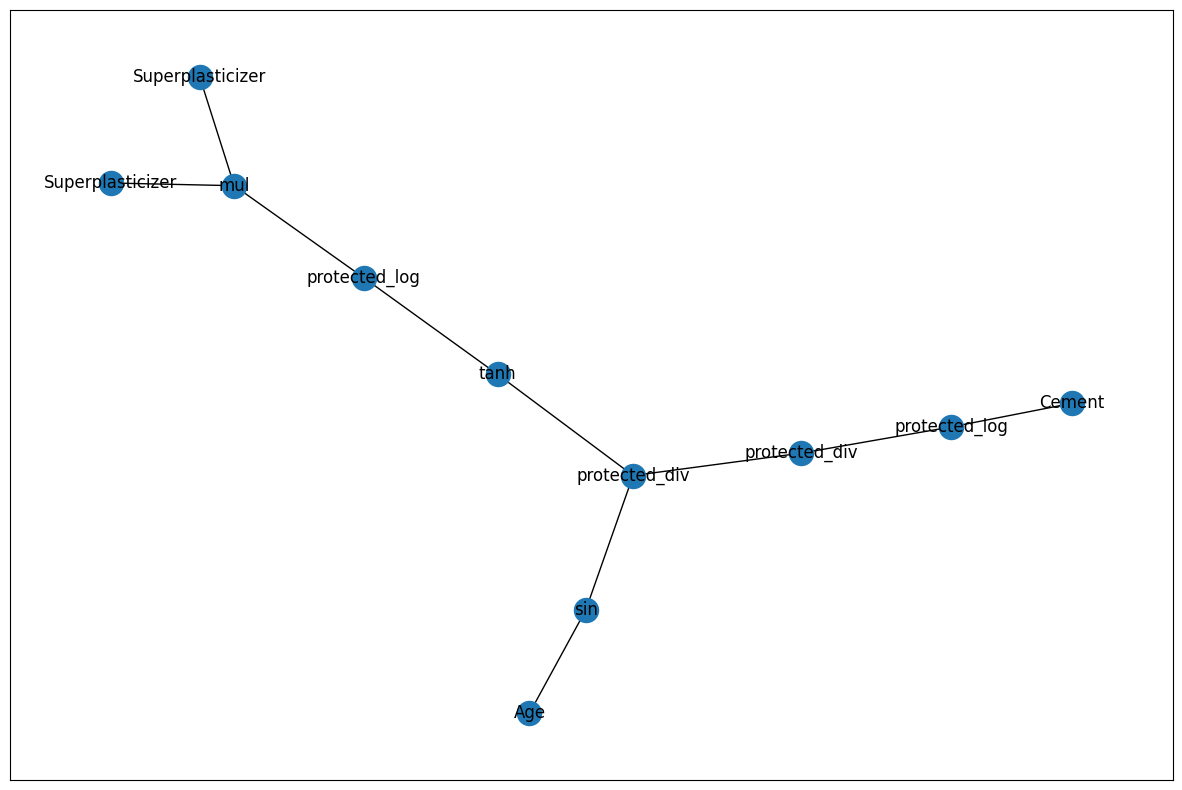

Feature as math expression: add(neg(cos(Fly_Ash)), Age) 



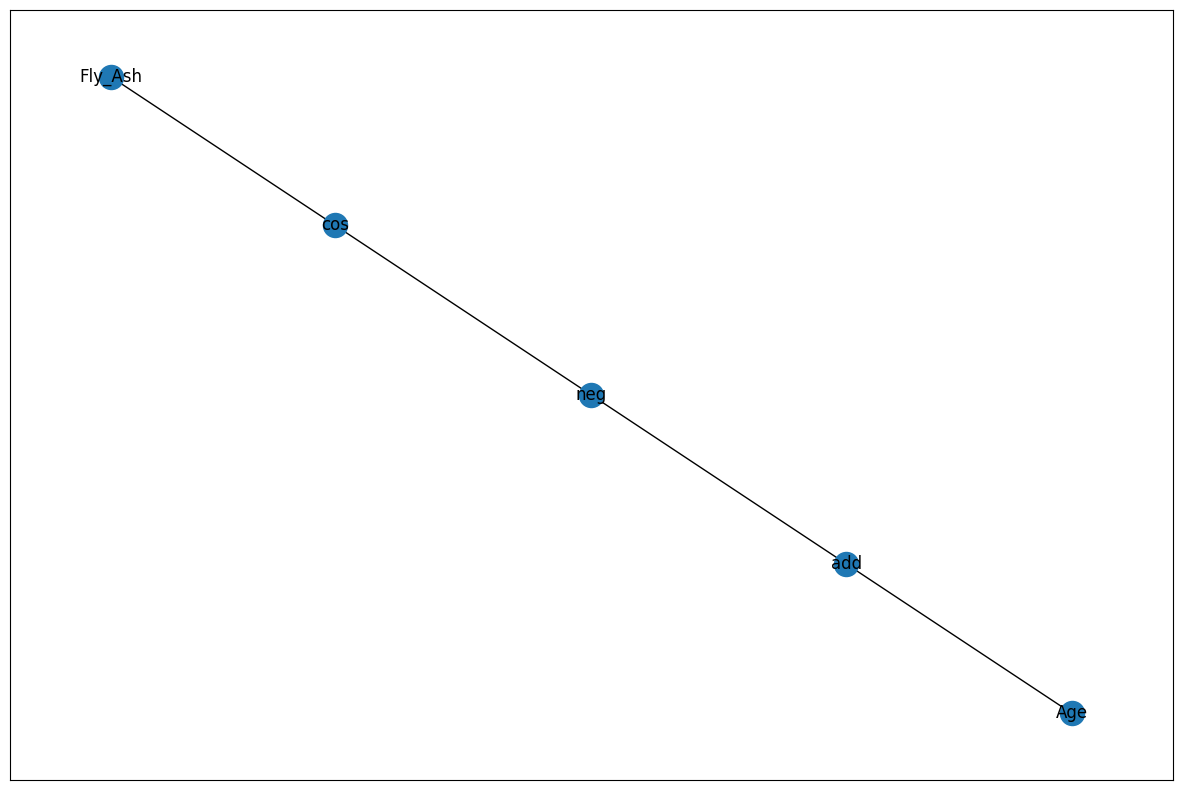

After feature creation, decision tree regression R2 score was equal to 0.54362

With previous data, it was 0.63875

Optimal contains 75.0% less columns than the original dataset, list of columns: evolved_feature_1, evolved_feature_2


In [29]:
# Evolve a new set of features
x_train_2_reg = pd.DataFrame({})
x_test_2_reg = pd.DataFrame({})
x_val_2_reg = pd.DataFrame({})

old_r2 = 100000
new_r2 = 1
feature_count = 0

while new_r2 - old_r2 < 0:
    old_r2 = new_r2
    feature_count += 1
    optimizer = PymooOptimizer(pd.concat([x_train_reg, x_train_2_reg], axis=1), pd.concat([x_val_reg, x_val_2_reg], axis=1), y_train_reg, y_val_reg)
    best_feature_func, best_individual = optimizer.evolve_new_feature(epochs=50, heuristics=Benchmark.regressor_r2_score, verbose=False, target_train = x_train_2_reg, target_test = x_val_2_reg)
    print("Feature as math expression:", best_individual, "\n")
    
    nodes, edges, labels = gp.graph(best_individual)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = nx.spring_layout(g)

    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(g, pos)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)
    plt.show()
    
    x_train_2_reg[f'evolved_feature_{feature_count}'] = pd.concat([x_train_reg, x_train_2_reg], axis=1).apply(lambda row: best_feature_func(*row), axis=1)
    x_test_2_reg[f'evolved_feature_{feature_count}'] = pd.concat([x_test_reg, x_test_2_reg], axis=1).apply(lambda row: best_feature_func(*row), axis=1)
    x_val_2_reg[f'evolved_feature_{feature_count}'] = pd.concat([x_val_reg, x_val_2_reg], axis=1).apply(lambda row: best_feature_func(*row), axis=1)
    
    new_r2 = np.round(Benchmark.regressor_r2_score(x_train_2_reg, x_test_2_reg, y_train_reg, y_test_reg), 5)


print(f'After feature creation, decision tree regression R2 score was equal to {new_r2}\n\n' +
        f'With previous data, it was {raw_score}\n\n' +
        f'Optimal contains {100 - np.round(x_train_2_reg.shape[1] / x_train_reg.shape[1] * 100, 1)}% less columns than the original dataset, list of columns: {", ".join(x_train_2_reg.columns.tolist())}')

In [62]:
from evolutionary_forest.forest import EvolutionaryForestRegressor
from evolutionary_forest.utils import get_feature_importance, plot_feature_importance, feature_append
from sklearn.metrics import r2_score

r = EvolutionaryForestRegressor(max_height=3, normalize=True, select='AutomaticLexicase',
                                gene_num=10, boost_size=100, n_gen=20, n_pop=200, cross_pb=1,
                                base_learner='Random-DT', verbose=True)
r.fit(x_train_reg, y_train_reg)
print(r2_score(y_test_reg, r.predict(x_test_reg)))

C:\Users\HP\Documents\Python\lib\site-packages\deap\gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


data shape (103, 8) (103,)
   	      	                                                          fitness                                                           	                                  size                                  
   	      	----------------------------------------------------------------------------------------------------------------------------	------------------------------------------------------------------------
gen	nevals	25%          	75%         	avg        	gen	max         	median      	min          	nevals	std         	25%	75%	avg 	gen	max	median	min	nevals	std     
0  	200   	[-0.09915394]	[0.17129995]	[0.0291863]	0  	[0.47685364]	[0.02830097]	[-0.77449458]	200   	[0.21255568]	4  	4  	3.94	0  	5  	4     	3  	200   	0.596992
defaultdict(<class 'int'>, {'1': 200})
P value of different population 0.05277472061605895
Mul(Cement, Sub(Water, Fine_Aggregate))
AQ(Sub(-1, Age), Mul(0, 0))
AQ(Add(Fly_Ash, Age), Add(Age, Fly_Ash))
Sub(1, Cement)
AQ(0, 1)
Sub(Wat

defaultdict(<class 'int'>, {'1': 200})
P value of different population 8.58254984926067e-06
Mul(Cement, Sub(Coarse_Aggregate, Fly_Ash))
Add(Add(Blast_Furnace_Slag, Superplasticizer), Mul(Coarse_Aggregate, Age))
Add(Age, -1)
AQ(Blast_Furnace_Slag, Cement)
Mul(Fine_Aggregate, Water)
Add(Superplasticizer, Fly_Ash)
Add(Superplasticizer, Blast_Furnace_Slag)
Sub(Age, Fly_Ash)
AQ(Add(AQ(Water, Coarse_Aggregate), Add(Coarse_Aggregate, Fly_Ash)), Mul(Age, Fine_Aggregate))
Sub(Water, Cement)
Unique Hash [53, 62, 49, 41, 42, 50, 47, 43, 54, 45]
number of features 423
archive size 100
Average Number of Active Genes 0.2155
11 	200   	[0.19546458] 	[0.41251548]	[0.28788356]	11 	[0.5918007] 	[0.3298086] 	[-0.27844248]	200   	[0.16377136]	4   	4  	3.86 	11 	5  	4     	3  	200   	0.490306
defaultdict(<class 'int'>, {'1': 200})
P value of different population 3.4453611315208247e-06
Mul(Cement, Sub(Coarse_Aggregate, Fly_Ash))
Add(Add(Blast_Furnace_Slag, Superplasticizer), Mul(Coarse_Aggregate, Age))
Add(

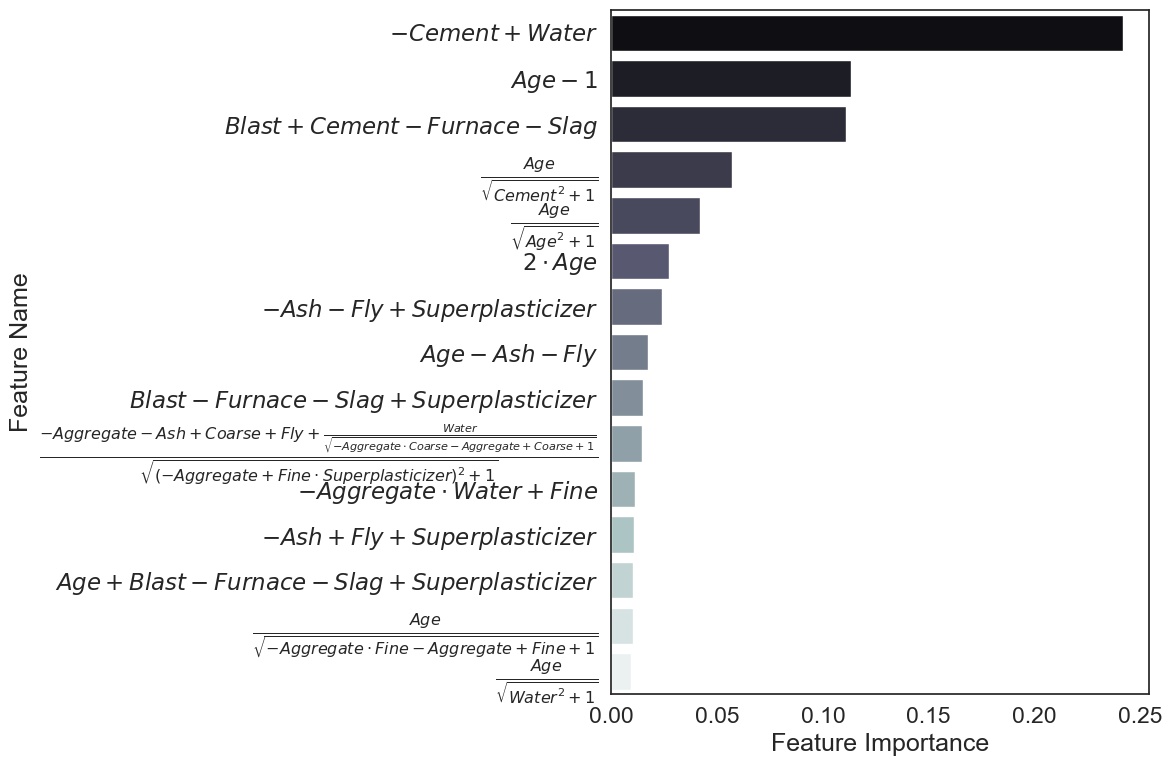

In [63]:
# Calculate and plot feature importance
feature_importance_dict = get_feature_importance(r)
plot_feature_importance(feature_importance_dict)

In [64]:
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

# Synthesize new features
code_importance_dict = get_feature_importance(r, simple_version=False)
top_features = list(code_importance_dict.keys())[:len(code_importance_dict) // 2]
new_train = feature_append(r, r.x_scaler.transform(x_train_reg), top_features, only_new_features=True)
new_test = feature_append(r, r.x_scaler.transform(x_test_reg), top_features, only_new_features=True)

# Train a new model on synthesized features
new_r = RandomForestRegressor()
new_r.fit(new_train, y_train_reg)
print(r2_score(y_test_reg, new_r.predict(new_test)))

0.73286185266999


In [73]:
from lightgbm import LGBMRegressor

regressor_list = ['RF', 'ET', 'AdaBoost', 'GBDT', 'DART', 'XGBoost', 'LightGBM']

# Normalize training and testing data
x_train_reg, x_test_reg = r.x_scaler.transform(x_train_reg), r.x_scaler.transform(x_test_reg)

# Get feature importance and select top features
code_importance_dict = get_feature_importance(r, simple_version=False)
top_features = list(code_importance_dict.keys())[:len(code_importance_dict.keys()) // 2]

# Replace the original dataset with new features
new_train = feature_append(r, x_train_reg, top_features, only_new_features=True)
new_test = feature_append(r, x_test_reg, top_features, only_new_features=True)

# Define regressors
regressor_dict = {
    'RF': RandomForestRegressor(n_estimators=200, n_jobs=-1),
    'ET': ExtraTreesRegressor(n_estimators=200, n_jobs=-1),
    'AdaBoost': AdaBoostRegressor(n_estimators=200),
    'GBDT': GradientBoostingRegressor(n_estimators=200),
    'DART': LGBMRegressor(n_jobs=1, n_estimators=200, boosting_type='dart',
                            xgboost_dart_mode=True),
    'XGBoost': XGBRegressor(n_jobs=1, n_estimators=200),
    'LightGBM': LGBMRegressor(n_jobs=1, n_estimators=200),
}

scores_base = []
scores_enhanced = []

# Train and evaluate regressors on original and new features
for regr in regressor_list:
    regressor = regressor_dict[regr]
    
    # Train on original features
    regressor.fit(x_train_reg, y_train_reg)
    score = r2_score(y_test_reg, regressor.predict(x_test_reg))
    scores_base.append((regr, score))

    # Train on new features
    regressor.fit(new_train, y_train_reg)
    score = r2_score(y_test_reg, regressor.predict(new_test))
    scores_enhanced.append((regr, score))

# Calculate mean scores for each algorithm
base_frame = pd.DataFrame(scores_base, columns=['algorithm', 'score'])
print(base_frame.groupby(['algorithm']).mean())

improved_frame = pd.DataFrame(scores_enhanced, columns=['algorithm', 'score'])
print(improved_frame.groupby(['algorithm']).mean())

# Calculate the improvement in scores
base_score = base_frame.groupby(['algorithm']).mean()
improved_score = improved_frame.groupby(['algorithm']).mean()
print(improved_score - base_score)

C:\Users\HP\Documents\Python\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\HP\Documents\Python\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 103, number of used features: 8
[LightGBM] [Info] Start training from score 36.249515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 103, number of used features: 8
[LightGBM] [Info] Start training from score 36.249515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

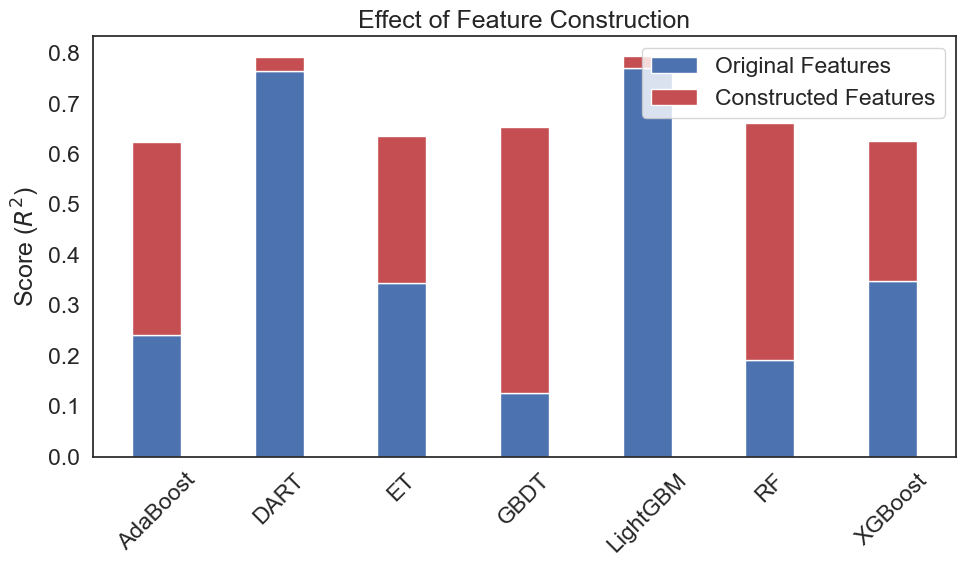

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", font_scale=1.5)
width = 0.4
fig, ax = plt.subplots(figsize=(10, 6))

# Plot scores for original features
ax.bar(base_score.index, base_score['score'], width, label='Original Features')

# Calculate score differences
difference = improved_score['score'] - base_score['score']

# Choose bar colors based on score improvement
colors = np.where(difference > 0, 'r', 'y')

# Plot score differences for constructed features
ax.bar(base_score.index, difference, width, bottom=base_score['score'],
       label='Constructed Features', color=colors)

# Set labels and title
ax.set_ylabel('Score ($R^2$)')
ax.set_title('Effect of Feature Construction')
ax.legend()

# Format the x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()